In [1]:
import pandas
dataRaw = pandas.read_csv('~/Data/Insight/employee_retention_data.csv')

In [2]:
# Count number of people joining and quiting each day
joinCount = dataRaw.groupby(['company_id','join_date']).size().reset_index(name='join_count')
quitCount = dataRaw.groupby(['company_id','quit_date']).size().reset_index(name='quit_count')

# Merge (i.e. join) join and quit tables
mergedCount = pandas.merge(joinCount.rename(columns={'join_date':'day'}),
                  quitCount.rename(columns={'quit_date':'day'}), how='outer', 
                  left_on=['day','company_id'], right_on=['day','company_id'])

# Sort by date
mergedCount = mergedCount.fillna(0)
mergedCount = mergedCount.sort_values(['company_id','day'])

# Get cumulative sum of join and quit counts, then subtract the difference to get headcount
mergedCount['joinSum']=mergedCount.groupby(['company_id'])['join_count'].apply(lambda x:x.cumsum())
mergedCount['quitSum']=mergedCount.groupby(['company_id'])['quit_count'].apply(lambda x:x.cumsum())

mergedCount['employee_headcount']=mergedCount['joinSum'].sub(mergedCount['quitSum'])
headCount=mergedCount.drop(['join_count','quit_count','joinSum','quitSum'], 1)

print headCount

      company_id         day  employee_headcount
0              1  2011-01-24                25.0
1              1  2011-01-25                27.0
2              1  2011-01-26                29.0
3              1  2011-01-31                59.0
4              1  2011-02-01                66.0
5              1  2011-02-02                67.0
6              1  2011-02-07                99.0
7              1  2011-02-08               102.0
8              1  2011-02-09               104.0
9              1  2011-02-14               129.0
10             1  2011-02-15               130.0
11             1  2011-02-16               132.0
12             1  2011-02-22               156.0
13             1  2011-02-23               159.0
14             1  2011-02-28               178.0
15             1  2011-03-02               181.0
16             1  2011-03-03               182.0
17             1  2011-03-07               210.0
18             1  2011-03-09               211.0
19             1  20

In [3]:
import numpy as np
data = dataRaw

# First fill in N/A quit dates with a dummy value
latest_date = data['quit_date'].max()
isNA = data['quit_date'].isnull()
data['filled_quit_date'] = data['quit_date'].fillna(latest_date)

# Then find longest anyone has stayed at a company. This is the longest measurable longevity of any employee
data['join_date'] = pandas.to_datetime(data['join_date'])
data['filled_quit_date'] = pandas.to_datetime(data['filled_quit_date'])
data['duration'] = data['filled_quit_date'].sub(data['join_date'], axis=0)

# And add the longest duration to anyone who hasn't quit yet and has been working for
# at least the median number of days





# Actually never mind, just take out outliers...
keep = (data['seniority'].values < 40) & (data['quit_date'].isnull())
data = data[keep]
depts = pandas.get_dummies(data['dept'])

# ...and do a regression
nposts = len(data)
test = ((np.arange(nposts) % 10) == 0) | ((np.arange(nposts) % 10) == 3)
train = np.logical_not(test)
ntrain = len(np.where(train)[0])

# Columns are:
# employee_id  company_id  dept  seniority  salary  join_date  quit_date  filled_quit_date  duration
# Depts are:
# customer_service  data_science  design  engineer  marketing  sales

# Normalize data
nfeatures = 9
if True:
    data_model = np.zeros([nposts,nfeatures])
    data_model[:,0] = data['company_id'].values
    data_model[:,1] = data['seniority'].values
    data_model[:,2] = data['salary'].values
    data_model[:,3] = depts['customer_service'].values
    data_model[:,4] = depts['data_science'].values
    data_model[:,5] = depts['design'].values
    data_model[:,6] = depts['engineer'].values
    data_model[:,7] = depts['marketing'].values
    data_model[:,8] = depts['sales'].values
    
    feat_min = []
    feat_max = []
    feat_mean = []
    for i in range(nfeatures):
        feat_min.append(np.min(data_model[:,i]))
        feat_max.append(np.max(data_model[:,i]))
        feat_mean.append(np.mean(data_model[:,i]))
        data_model[:,i] = (data_model[:,i] - feat_mean[i]) / (feat_max[i] - feat_min[i])
    data_train = data_model[train,:]
    data_test = data_model[test,:]
    
    y_model = data['duration'].values
    y_min = np.min(y_model)
    y_max = np.max(y_model)
    y_mean = np.mean(y_model)
    y_model = (y_model - y_mean)  / (y_max - y_min)
    y_train = y_model[train]
    y_test = y_model[test]

nposts

11192

MSE: 0.049937
R2S: 0.000545


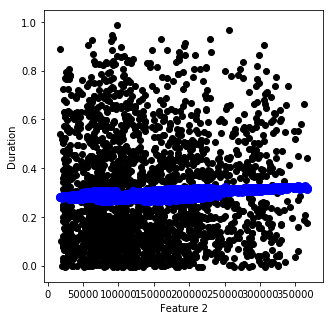

In [4]:
from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error as MSE, r2_score as R2S
import matplotlib.pyplot as plt

# Run regression

regr = linear_model.LinearRegression()
regr.fit(data_train, y_train)

y_pred = regr.predict(data_test)

print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)

fig = plt.figure(figsize=[5,5])
feat = 2
data_reverted = data_test[:,feat]*(feat_max[feat]-feat_min[feat])+feat_mean[feat]
plt.scatter( data_reverted, y_test,  color='black')
plt.scatter( data_reverted, y_pred, color='blue', linewidth=3)
plt.xlabel('Feature %d'%(feat))
plt.ylabel('Duration')
plt.show()


In [5]:
# Salary seems to be the best predictor
# Let's just use that

featureList = [2]
temp_data = data_model[:,featureList]
data_train = temp_data[train,:]
data_test = temp_data[test,:]

regr.fit(data_train, y_train)
y_pred = regr.predict(data_test)

print 'MSE: %8f'%MSE(y_test, y_pred)
print 'R2S: %8f'%R2S(y_test, y_pred)


# Only a little better

MSE: 0.049910
R2S: 0.001079
